# Machine Learning Prediction of Recessions





An Imbalanced Classification Approach

### **US**

This notebook is based on presentation slides which can be found here: 
https://fdpinstitute.org/resources/Documents/webinars%20thoughtleadership%20pieces%20etc/Al%20Yazdani%20Webinar%20July%208,%202020.pdf

In [ ]:
pip install quandl

In [ ]:
pip install yfinance

In [ ]:
pip install xgboost

In [ ]:
import pandas as pd 
import numpy as np 
import quandl 
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
import plotly as plotly
import plotly.graph_objs as go
import plotly.express as px
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

Load Data

Quick summary where I got the data:

Quandl:

1.   Recession
2.   Fed Funds
3.   Indpro
4.   nonfarm payroll
5.   unemployment

Market Watch:

1.   SPY500

Macrotrends:

1.   10 year Treasury Bond



In [ ]:
# Quandl; require API key
recession_data = quandl.get("FRED/USRECQP", collapse="monthly") 
fed_funds_data = quandl.get("FRED/FEDFUNDS", collapse="monthly")
indpro_data = quandl.get("FRED/INDPRO", collapse="monthly")
nonfarm_payroll_data = quandl.get("FRED/PAYEMS", collapse="monthly")
unemploy_data = quandl.get("FRED/UNEMPLOY", collapse="monthly")

In [ ]:
#Market 


In [ ]:
# load in merged data 
data = pd.read_csv('https://raw.githubusercontent.com/lumalik/recession-replication/master/data/replication_data.csv', index_col=0)
# fill missing recession data 
data["recession"] = data["recession"].fillna(method='bfill').fillna(method='ffill') 

In [ ]:
data["recession"].tail(10)

Date
2019-03-31    0.0
2019-04-30    0.0
2019-05-31    0.0
2019-06-30    0.0
2019-07-31    0.0
2019-08-31    1.0
2019-09-30    1.0
2019-10-31    1.0
2019-11-30    1.0
2019-12-31    1.0
Name: recession, dtype: float64

In [ ]:
px.line(data, x= data.index, y='recession')

In [ ]:
print("There are a total of {} months of recession in this data".format(data["recession"].sum()))

There are a total of 95.0 months of recession in this data


**Data Preparation**

In [ ]:
def log_diff(v): 
    log_diff = np.log(v/v.shift(1))
    return log_diff 

In [ ]:
# preprocessing 
data["slope_yc"] = (data["ty10"] - data["fedfunds"])
data["fedfunds"] = data["fedfunds"].diff()
data["indpro"] = log_diff(data["indpro"]) 
data["nonfarm"] =  log_diff(data["nonfarm"])
data["SP500"] =  log_diff(data["SP500"])
data["ty10"]  = (data["ty10"]).diff()
data["unemploy"] = log_diff(data["unemploy"])
data["recession"] = data["recession"].shift(1)

In [ ]:
data.head()

,fedfunds,nonfarm,indpro,SP500,ty10,unemploy,recession,slope_yc
Date,,,,,,,,
1959-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-28,-0.05,0.003994,0.019395,-0.000722,NaN,-0.025646,0.0,NaN
1959-03-31,0.37,0.006168,0.014302,0.000541,NaN,-0.042242,0.0,NaN
1959-04-30,0.16,0.005774,0.021079,0.038048,NaN,-0.062419,0.0,NaN
1959-05-31,-0.06,0.004286,0.014951,0.018750,NaN,-0.026101,0.0,NaN


In [ ]:
# drop missing values 
len_before = len(data)
data.dropna(inplace=True)
len_after = len(data)

print("Dropped {} rows".format(len_before - len_after))

Dropped 37 rows


**Class Imbalance**

In [ ]:
c1 = data["recession"].value_counts()[0]
c2 = data["recession"].value_counts()[1]
print(data["recession"].value_counts())
print("The minority class only makes up {} % ".format(round(c2/c1 * 100, 2)))

0.0    610
1.0     85
Name: recession, dtype: int64
The minority class only makes up 13.93 % 


In [ ]:
# get x and y 
X = data.drop(['recession'], axis=1)
y = data["recession"]

In [ ]:
# divide in train test according to paper 
X_train, y_train =  (X.loc["1962-02-28":"2007-01-01"], y.loc["1962-02-28":"2007-01-01"])
X_test, y_test =  (X.loc["2007-01-01":], y.loc["2007-01-01":])

In [ ]:
## Sampling techniques

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# oversample using SMOTE 
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# undersample randomly
rus = RandomUnderSampler(random_state=42)
X_train_rnd, y_train_rnd  = rus.fit_resample(X_train, y_train)

In [ ]:
train_test_pairs = {"Normal":(X_train, y_train), 
                    "SMOTE":(X_train_smote, y_train_smote), 
                    "Random Undersampling":(X_train_rnd, y_train_rnd)}

In [ ]:
clfs = {"Logistic Regression": LogisticRegression(),
       "Decision Tree": tree.DecisionTreeClassifier(),
       "Random Forest": RandomForestClassifier(max_depth=15, 
                                                      n_estimators=200, 
                                                      class_weight = "balanced_subsample", 
                                                      random_state=42),
        "Extra Tree": ExtraTreesClassifier(max_depth=15, 
                                                      n_estimators=200, 
                                                      class_weight = "balanced", 
                                                      random_state=42),
        
        "Neural Network": MLPClassifier(hidden_layer_sizes=(150,100,50), 
                                                    max_iter=200,
                                                    activation = 'relu',
                                                    solver='adam',
                                                    random_state=42)}

# **Modelling**

In [ ]:
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for label, pair in train_test_pairs.items(): 
    clf = RandomForestClassifier(max_depth=15, 
                                 n_estimators=200, 
                                 class_weight = "balanced_subsample", 
                                 random_state=42)
    clf.fit(pair[0], pair[1])
    y_pred= clf.predict(X_test) 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test, clf.predict(X_test))

    name = f"{label} (AUC={auc:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
xaxis_title='False Positive Rate',
yaxis_title='True Positive Rate',
yaxis=dict(scaleanchor="x", scaleratio=1),
xaxis=dict(constrain='domain'),
width=900, height=700
)
fig.update_layout(title_text="Comparing Sampling Approaches, by Rachel")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for name, clf in clfs.items(): 
    clf.fit(X_train_rnd, y_train_rnd)
    y_pred= clf.predict(X_test) 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test, clf.predict(X_test))

    name = f"{name} (AUC={auc:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=900, height=700
)
fig.update_layout(title_text="Figure 1: Prediction Model Comparison, by Rachel")
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [ ]:
print(clf)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(150, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [ ]:
y_pred = clf.predict(X_test)
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0.])

Trading Strategy

In [ ]:
import yfinance as yf

results = pd.DataFrame()

results["SPY"] = yf.Ticker("^GSPC").history(period='1d', start='2007-1-1', end= "2019-12-31").Close.resample("M").mean()
results["GLD"] = yf.Ticker("GLD").history(period='1d', start='2007-1-1', end= "2019-12-31").Close.resample("M").mean()
results["VIX"] = yf.Ticker("^VIX").history(period='1d', start='2007-1-1', end= "2019-12-31").Close.resample("M").mean()

In [ ]:
# strategies
pred_shift_back = pd.Series(y_pred).shift(-1).fillna(method='ffill')
spy_long_preds = (pred_shift_back -1) *(-1) 
results["SPY Long"] = results["SPY"].pct_change()
results["SPY Long wo recessions"] = spy_long_preds.values * results["SPY Long"].values 
results["SPY Long add GLD"] = ((results["GLD"].pct_change().values * pred_shift_back) + results["SPY Long"].values).values
results["SPY Long add VIX"] = ((results["VIX"].pct_change().values * pred_shift_back) + results["SPY Long"].values).values
fig = go.Figure()
fig.add_scatter(x= results.index, y=results['SPY Long'].cumsum(), mode='lines', name="SPY long")
fig.add_scatter(x= results.index, y=results["SPY Long wo recessions"].cumsum(), mode='lines', name="SPY wo recession")
fig.add_scatter(x= results.index, y=results["SPY Long add GLD"].cumsum(), mode='lines', name="SPY + GLD")
fig.add_scatter(x= results.index, y=results["SPY Long add VIX"].cumsum(), mode='lines', name="SPY + VIX")
fig.update_layout(title_text="Different Strategies during Recessions")
fig.show()

# **It is clear thatSPY + VIX (in times of predicted recessions) portfolio is the most profitable**


Predictions for the coming months

In [ ]:
# features 
fed_funds_data = quandl.get("FRED/FEDFUNDS", collapse="monthly", api_key="VUCaDHTMGVn5xMsaqPtS")
indpro_data = quandl.get("FRED/INDPRO", collapse="monthly", api_key="VUCaDHTMGVn5xMsaqPtS")
nonfarm_payroll_data = quandl.get("FRED/PAYEMS", collapse="monthly", api_key="VUCaDHTMGVn5xMsaqPtS")
unemploy_data = quandl.get("FRED/UNEMPLOY", collapse="monthly", api_key="VUCaDHTMGVn5xMsaqPtS")
spy = yf.Ticker("^GSPC").history(period='1d', start='2019-1-1').Close.resample("M").mean()
ty10 = yf.Ticker("^TNX").history(period='1d', start='2019-1-1').Close.resample("M").mean()

In [ ]:
# subsetting recent data  
data = pd.DataFrame()
data["fedfunds"] = fed_funds_data.loc["01-01-2020":].Value
data["nonfarm"] = nonfarm_payroll_data.loc["01-01-2020":].Value
data["indpro"] = indpro_data.loc["01-01-2020":].Value
data["SP500"] = spy.loc["01-01-2020":]
data["ty10"] = ty10.loc["01-01-2020":]
data["unemploy"] = unemploy_data.loc["01-01-2020":].Value

# preprocessing 
data["slope_yc"] = (data["ty10"] - data["fedfunds"]).diff()
data["fedfunds"] = data["fedfunds"].diff()
data["indpro"] = log_diff(data["indpro"]).fillna(method="ffill") # no recent data
data["nonfarm"] =  log_diff(data["nonfarm"])
data["SP500"] =  log_diff(data["SP500"])
data["ty10"]  = (data["ty10"]).diff()
data["unemploy"] = log_diff(data["unemploy"])

In [ ]:
#get up to date data 
data.dropna(inplace=True)
print(clf.predict(data))

[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
print(clf.predict_proba(data))

[[9.73148779e-01 2.68512208e-02]
 [7.65968244e-06 9.99992340e-01]
 [1.12139187e-11 1.00000000e+00]
 [9.99177051e-01 8.22949190e-04]
 [9.99906655e-01 9.33453402e-05]
 [9.99100713e-01 8.99286718e-04]
 [9.99712245e-01 2.87755059e-04]
 [9.87260129e-01 1.27398709e-02]
 [9.98142925e-01 1.85707511e-03]
 [9.93463097e-01 6.53690283e-03]
 [9.86673608e-01 1.33263916e-02]
 [9.94681165e-01 5.31883532e-03]
 [9.25834719e-01 7.41652809e-02]
 [9.88241672e-01 1.17583281e-02]]


 the predicted probability for a recession was far bigger 5-6 months ago!

In [ ]:
data.dropna(inplace=True)
data["recession_proba"] = clf.predict_proba(data)[:,1]

In [ ]:
fig = go.Figure()
fig.add_scatter(x= data.index, y=data["recession_proba"], mode='lines', name="SPY long")
fig.update_layout(title_text="Confidence in Recession according to the model")
fig.show()

## **Deep-dive in Machine Learning**

In [ ]:
pip install dtreeviz

In [ ]:
pip install pdpbox

In [ ]:
from dtreeviz.trees import *
from pdpbox import pdp, get_dataset, info_plots

In [ ]:
clf = RandomForestClassifier(max_depth=15, 
                             n_estimators=200, 
                             class_weight = "balanced_subsample", 
                             random_state=42)
clf.fit(X_train_rnd,y_train_rnd)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

Permutation Importance

In [ ]:
# Permutation Importance 
# see https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig = go.Figure()
for i in range(0, len(X_test.columns)):
    fig.add_trace(go.Box(x = result.importances[sorted_idx][i], name=X_test.columns[sorted_idx][i]))

fig.update_layout(title_text="Figure 3: Permutation Importance, by Rachel")
fig.show()

In [ ]:
#ICE Plot
pdp_nonfarm = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns, feature='nonfarm'
)
pdp_fedfunds = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns, feature='fedfunds'
)
pdp_indpro = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns, feature='indpro'
)
pdp_slopeyc = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns, feature='slope_yc'
)
pdp_sp500 = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns, feature='SP500'
)
pdp_unemploy = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns, feature='unemploy'
)
pdp_ty10 = pdp.pdp_isolate(
    model=clf, dataset=X, model_features=X.columns, feature='ty10'
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


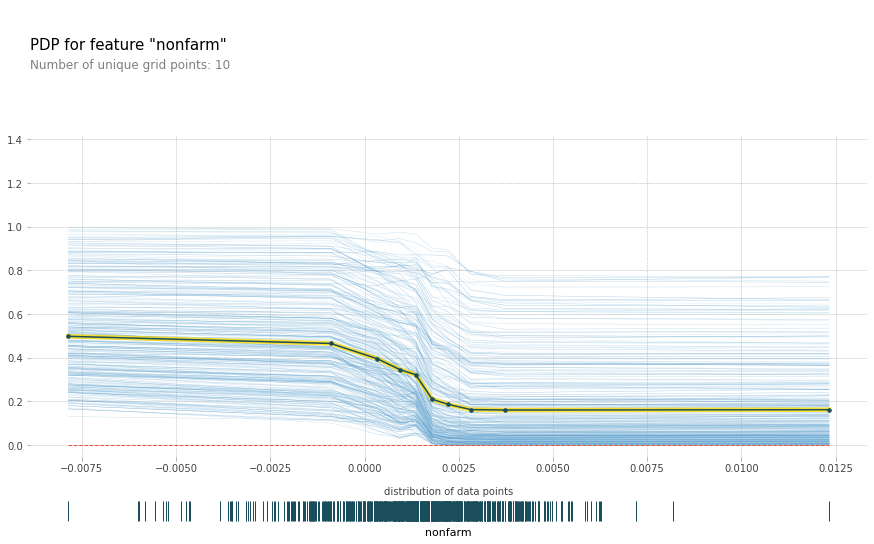

In [ ]:
fig, axes = pdp.pdp_plot(pdp_nonfarm, 
                         'nonfarm', 
                         plot_lines=True, 
                         center=False, 
                         frac_to_plot=0.5,
                         plot_pts_dist=True, 
)

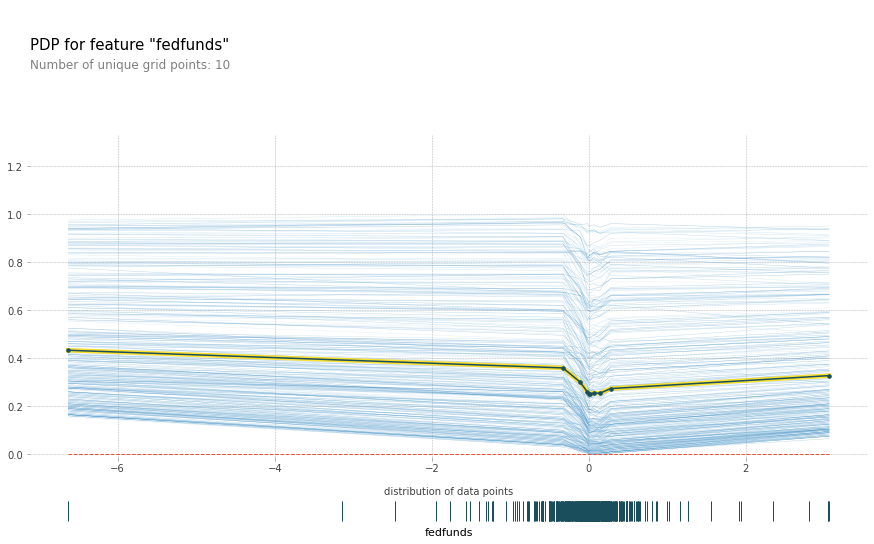

In [ ]:
fig, axes = pdp.pdp_plot(pdp_fedfunds, 
                         'fedfunds', 
                         plot_lines=True, 
                         center=False, 
                         frac_to_plot=0.5,
                         plot_pts_dist=True, 
)

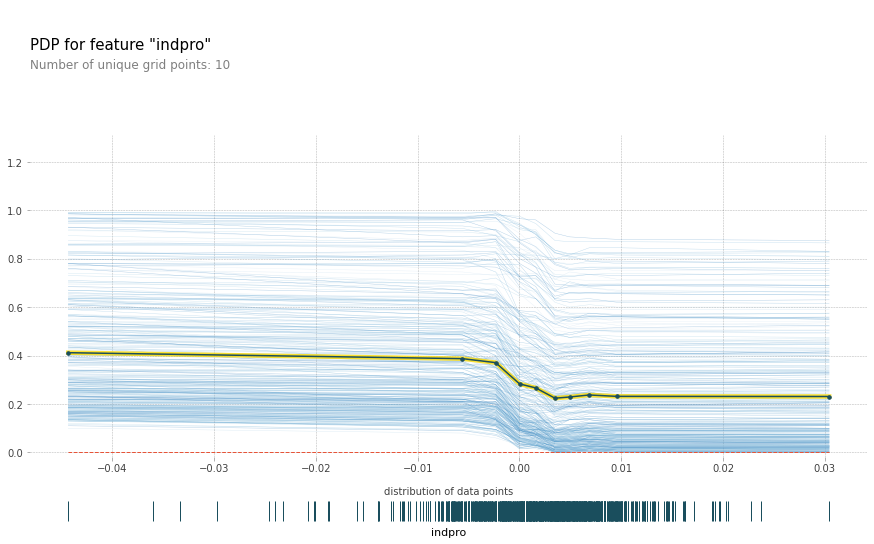

In [ ]:
fig, axes = pdp.pdp_plot(pdp_indpro, 
                         'indpro', 
                         plot_lines=True, 
                         center=False, 
                         frac_to_plot=0.5,
                         plot_pts_dist=True, 
)

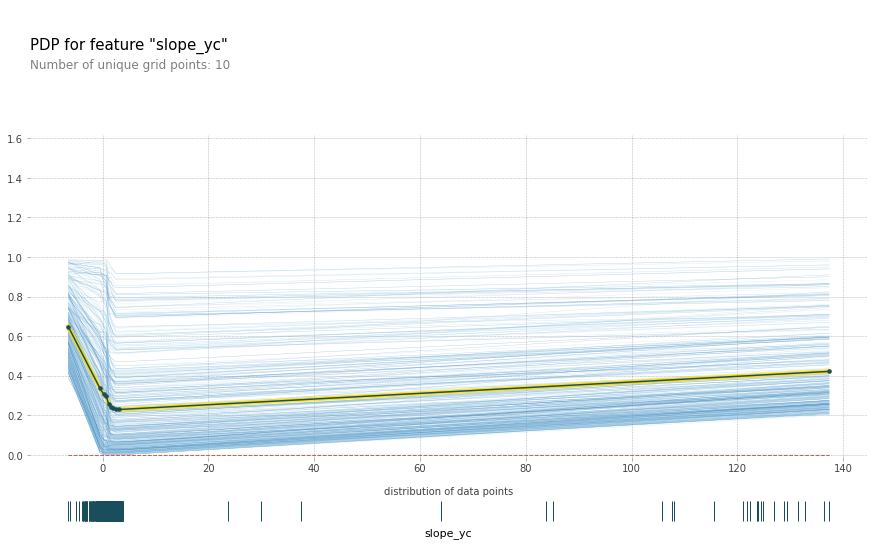

In [ ]:
fig, axes = pdp.pdp_plot(pdp_slopeyc, 
                         'slope_yc', 
                         plot_lines=True, 
                         center=False, 
                         frac_to_plot=0.5,
                         plot_pts_dist=True, 
)

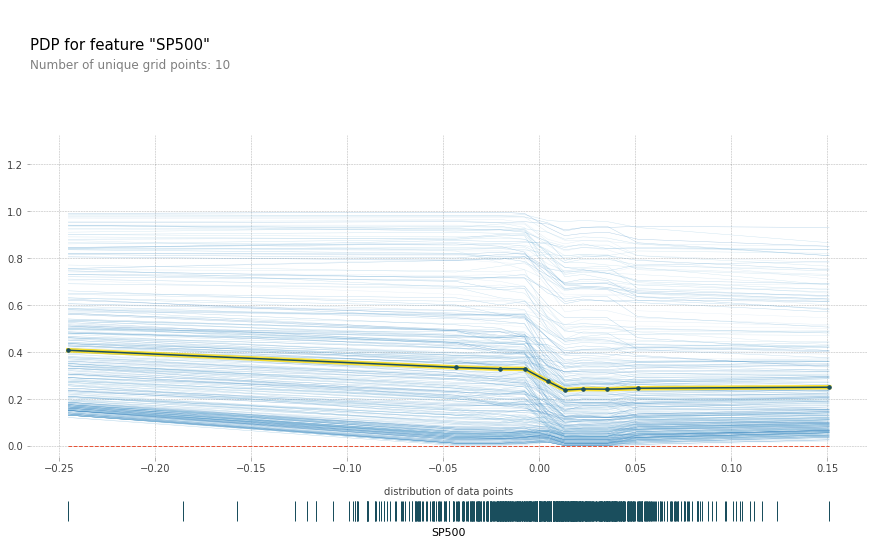

In [ ]:
fig, axes = pdp.pdp_plot(pdp_sp500, 
                         'SP500', 
                         plot_lines=True, 
                         center=False, 
                         frac_to_plot=0.5,
                         plot_pts_dist=True, 
)

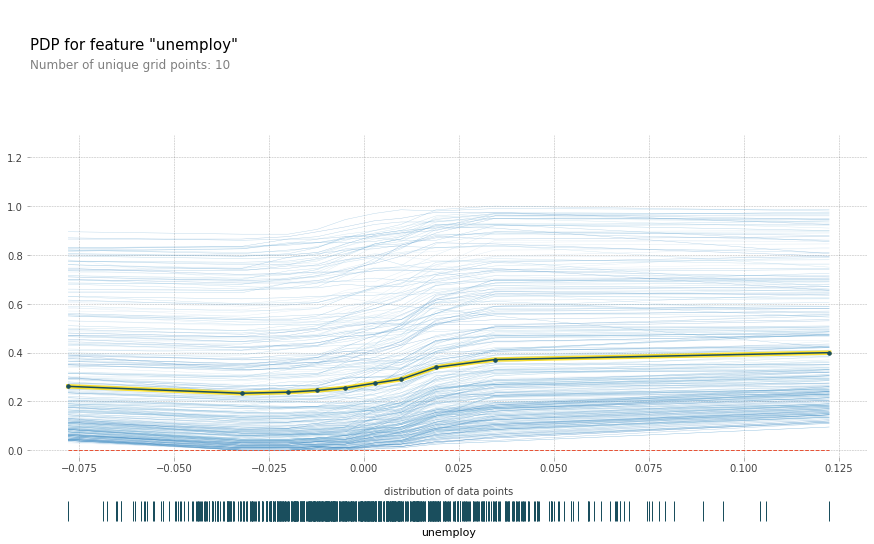

In [ ]:
fig, axes = pdp.pdp_plot(pdp_unemploy, 
                         'unemploy', 
                         plot_lines=True, 
                         center=False, 
                         frac_to_plot=0.5,
                         plot_pts_dist=True, 
)

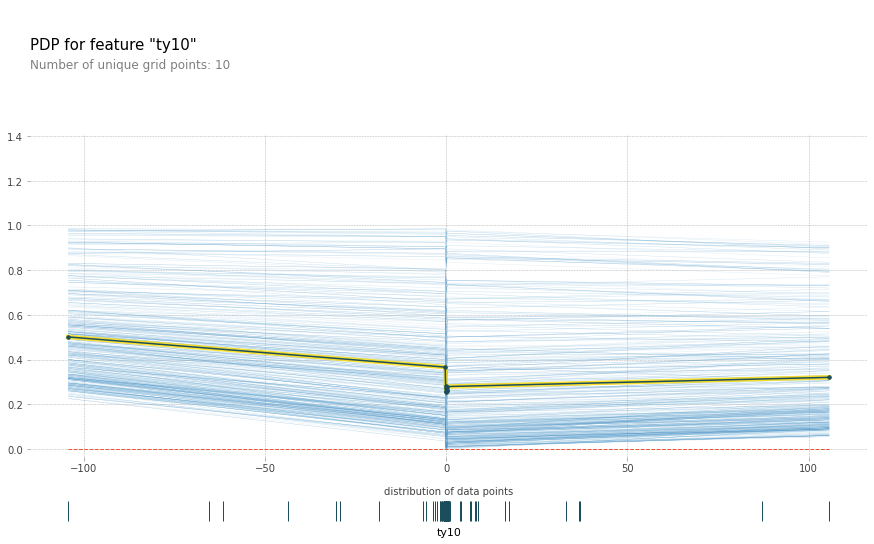

In [ ]:
fig, axes = pdp.pdp_plot(pdp_ty10, 
                         'ty10', 
                         plot_lines=True, 
                         center=False, 
                         frac_to_plot=0.5,
                         plot_pts_dist=True, 
)

## **SHAPLEY VALUE**

In [ ]:
pip install shap

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

In [ ]:
shap.summary_plot??

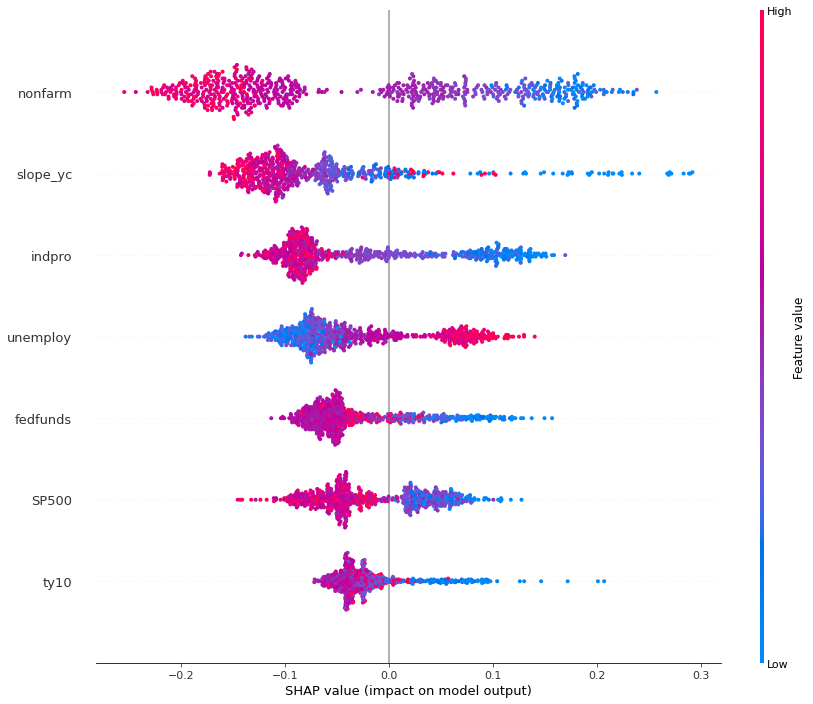

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values[1], X, plot_type="dot",plot_size=(14,12))

In [ ]:
shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(X)

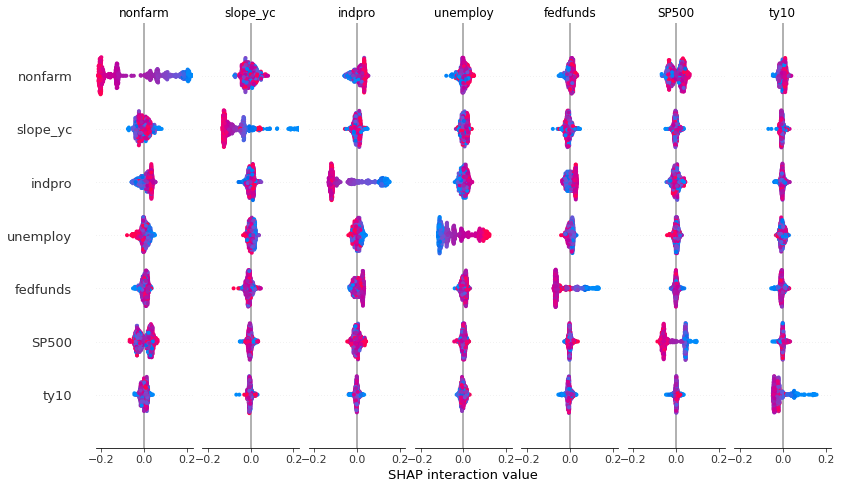

In [ ]:
# summaries interaction effect
shap.summary_plot(shap_interaction_values[1], X, plot_size=(14,16))

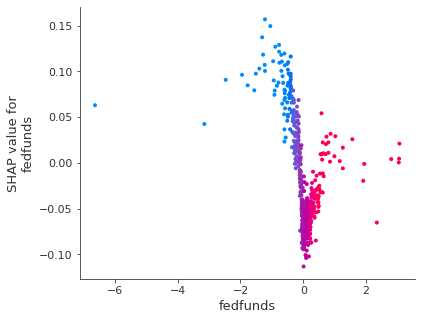

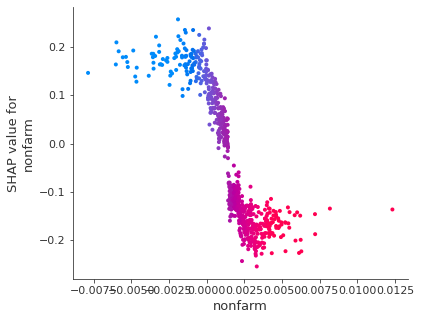

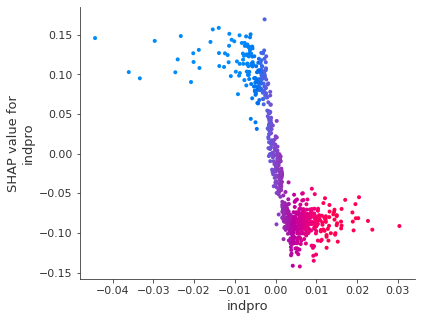

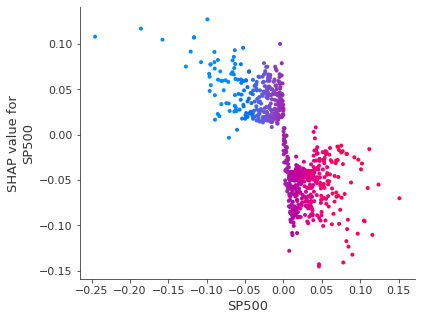

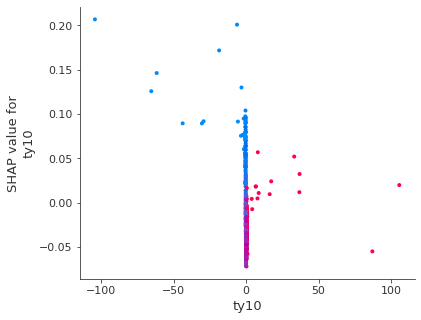

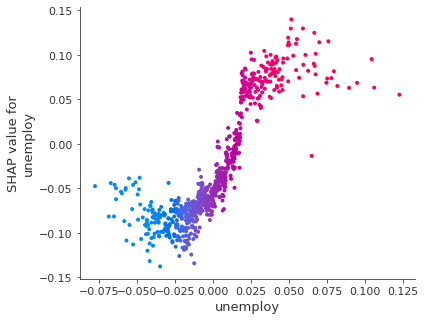

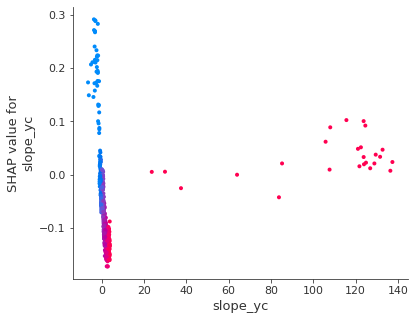

In [ ]:
for feature in X.columns: 
    shap.dependence_plot(feature, shap_values[1], X, interaction_index=feature)

Partial Dependence Plot **

In [ ]:
interactions = [
    ['nonfarm', 'unemploy'],
    ['nonfarm', 'indpro'],
    ['fedfunds', 'unemploy'],
    ['fedfunds', 'SP500']
]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


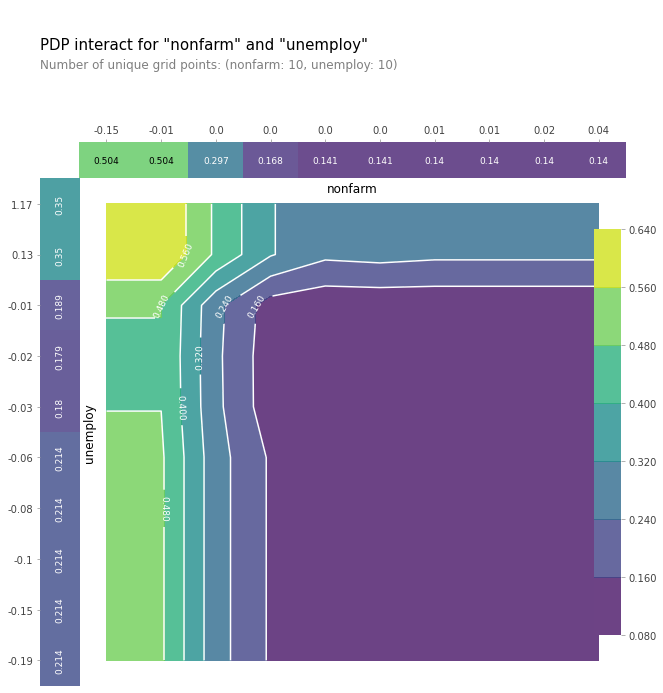

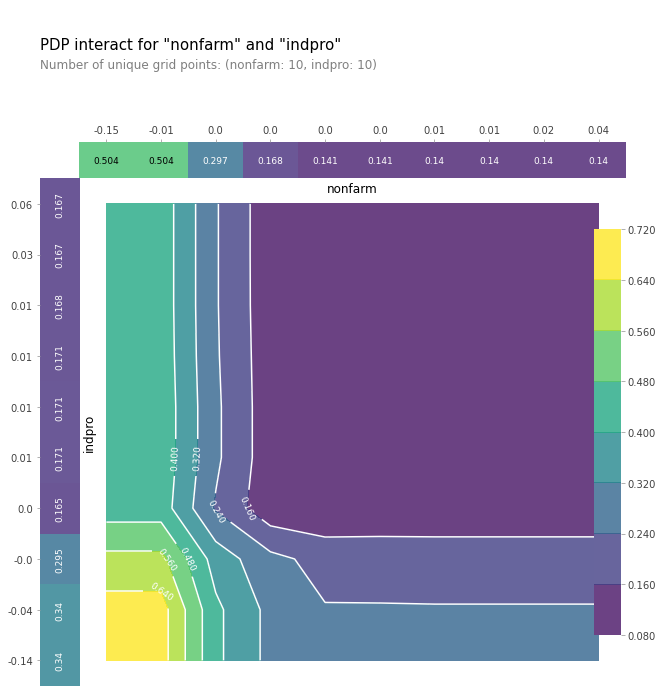

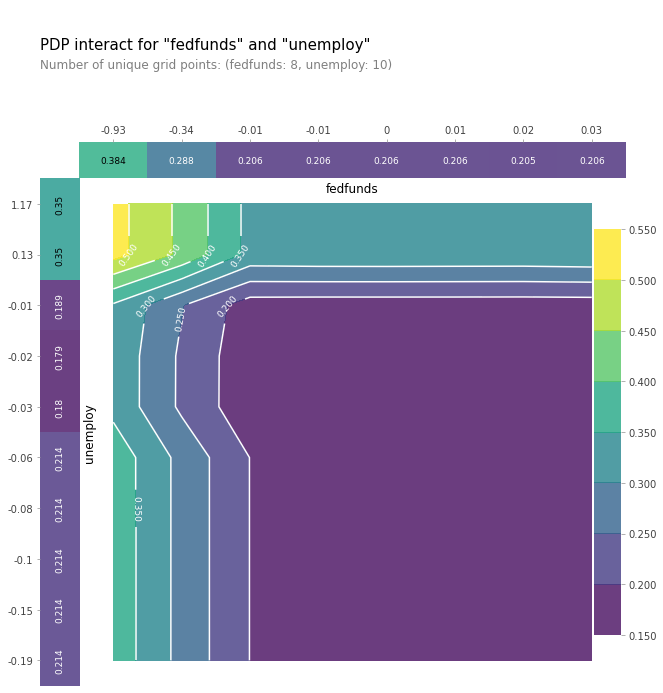

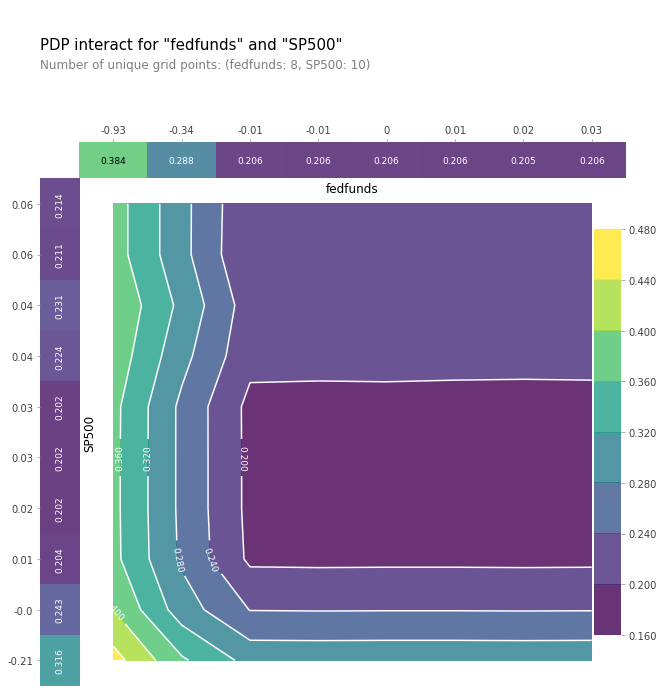

In [ ]:
for i in interactions: 
    inter1 = pdp.pdp_interact(model=clf, dataset=data, model_features=X.columns, features=i)
    fig, axes = pdp.pdp_interact_plot(inter1, i, 
                                  plot_type='contour', 
                                  x_quantile=True, plot_pdp=True)

## **Tree Interpreter**

In [ ]:
dtree = tree.DecisionTreeClassifier(max_depth=3)  
dtree.fit(X_train_rnd, y_train_rnd)
viz = dtreeviz(dtree, 
               X, 
               y,
               target_name='recession',
               feature_names=X.columns, 
               class_names=["no","yes"]
              )  
              
viz.view()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


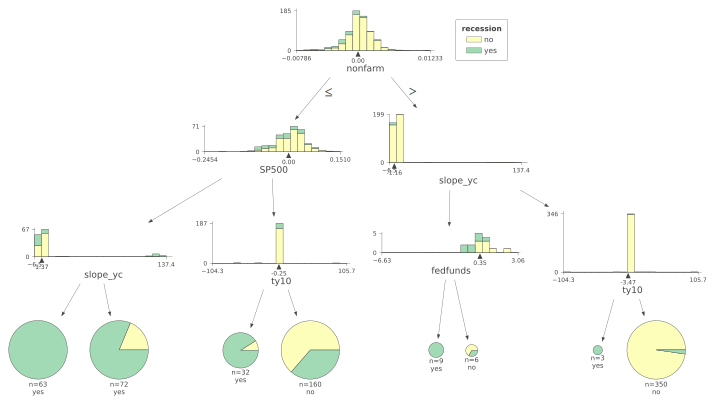

In [ ]:
from IPython.display import display
display(viz)

## Causal Interpretation

Direct Causal Effect -- Do the top predictors also have a direct effect on outcome of interest?

In [ ]:
classification = False
# order feature names according to shap values
vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(
    list(zip(shap_values.feature_names, vals)), columns=["features", "importance"]
)
feature_importance.sort_values(by=["importance"], ascending=False, inplace=True)
top_features = feature_importance["features"]

In [ ]:
from econml.solutions.causal_analysis import CausalAnalysis

ca = CausalAnalysis(
    top_features,
    categorical,
    heterogeneity_inds=None,
    classification=classification,
    nuisance_models="automl",
    heterogeneity_model="linear",
    n_jobs=-1,
)
ca.fit(pd.DataFrame(x_train, columns=boston_data.feature_names), y_train)

In [ ]:
# get global causal effect ordered by causal importance (pvalue)
global_summ = ca.global_causal_effect(alpha=0.05)
global_summ.sort_values(by="p_value")

In [ ]:
# helper function to plot error bar
def errorbar(res):
    xticks = res.index.get_level_values(0)
    lowererr = res["point"] - res["ci_lower"]
    uppererr = res["ci_upper"] - res["point"]
    xticks = [
        "{}***".format(t)
        if p < 1e-6
        else ("{}**".format(t) if p < 1e-3 else ("{}*".format(t) if p < 1e-2 else t))
        for t, p in zip(xticks, res["p_value"])
    ]
    plot_title = "Direct Causal Effect of Each Feature with 95% Confidence Interval, "
    plt.figure(figsize=(15, 5))
    plt.errorbar(
        np.arange(len(xticks)),
        res["point"],
        yerr=[lowererr, uppererr],
        fmt="o",
        capsize=5,
        capthick=1,
        barsabove=True,
    )
    plt.xticks(np.arange(len(xticks)), xticks, rotation=45)
    plt.title(plot_title)
    plt.axhline(0, color="r", linestyle="--", alpha=0.5)
    plt.ylabel("Average Treatment Effect")

In [ ]:
errorbar(global_summ)